## Advanced Lane Finding Project

The goals / steps of this project are the following:

* ~~Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.~~
* ~~Apply a distortion correction to raw images.~~
* ~~Use color transforms, gradients, etc., to create a thresholded binary image.~~
* ~~Apply a perspective transform to rectify binary image ("birds-eye view").~~
* ~~Detect lane pixels and fit to find the lane boundary.~~
* ~~Determine the curvature of the lane and vehicle position with respect to center.~~
* ~~Warp the detected lane boundaries back onto the original image.~~
* ~~Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.~~

---


## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from pylab import rcParams
from helper import *
%matplotlib inline

INIT_FIG_SIZE = rcParams['figure.figsize']

In [9]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

In [10]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [11]:
print('Calibration matrix: \n\n{}'.format(mtx))

Calibration matrix: 

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128937e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [12]:
print('Disotortion coefficients:\t{}'.format(dist))

Disotortion coefficients:	[[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


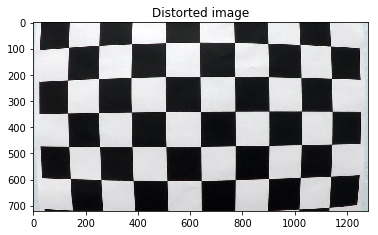

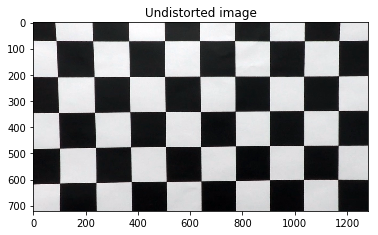

In [13]:
src = cv2.imread(images[0])
dst = cv2.undistort(src, mtx, dist)

plt.title('Distorted image')
plt.imshow(src)
plt.show()

plt.title('Undistorted image')
plt.imshow(dst)
plt.show()

## Apply a distortion correction to raw images

In [14]:
src = cv2.imread('../test_images/straight_lines1.jpg')[:,:,::-1]
dst = cv2.undistort(src, mtx, dist)

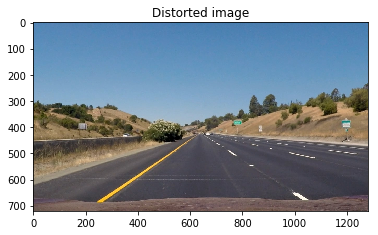

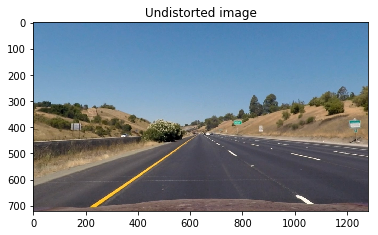

In [15]:
plt.title('Distorted image')
plt.imshow(src)
plt.show()

plt.title('Undistorted image')
plt.imshow(dst)
plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image

In [16]:
ksize = 3 

gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(9, 100))
mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))
S_binary = hls_thresh(dst, ctype='S',thresh=(130, 200))

combined_binary = np.zeros_like(gradx)
combined_binary[(((gradx == 1) & (mag_binary == 1) & (dir_binary == 1)) | (S_binary == 1)) ] = 1

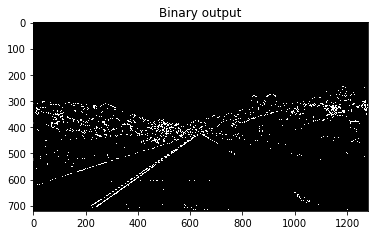

In [17]:
plt.title('Binary output')
plt.imshow(combined_binary, cmap='gray')
plt.show()

## Apply a perspective transform to rectify binary image ("birds-eye view")

In [18]:
IMAGE_H = 223
IMAGE_W = 1280

src_p = np.float32([[0, IMAGE_H], [1207, IMAGE_H], [0, 0], [IMAGE_W, 0]])
dst_p = np.float32([[563, IMAGE_H], [711, IMAGE_H], [0, 0], [IMAGE_W, 0]])

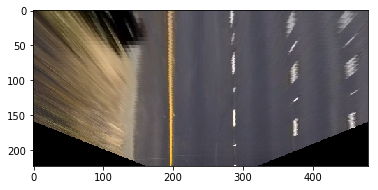

In [19]:
plt.imshow(warper(dst[450:(450+IMAGE_H)], src_p, dst_p)[:,400:-400])

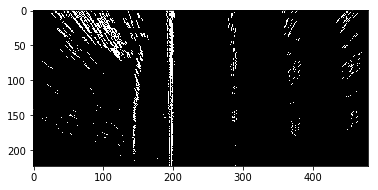

In [20]:
plt.imshow(255*warper(combined_binary[450:(450+IMAGE_H)], src_p, dst_p)[:,400:-400], cmap='gray')
plt.show()
rcParams['figure.figsize'] = INIT_FIG_SIZE

In [21]:
warped_img = 255*warper(combined_binary[450:(450+IMAGE_H)], src_p, dst_p)[:,550:-550]

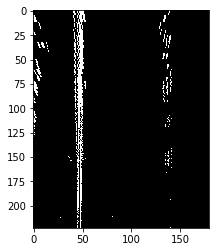

In [22]:
plt.imshow(warped_img, cmap='gray')

In [23]:
rcParams['figure.figsize'] = INIT_FIG_SIZE

## Detect lane pixels and fit to find the lane boundary.

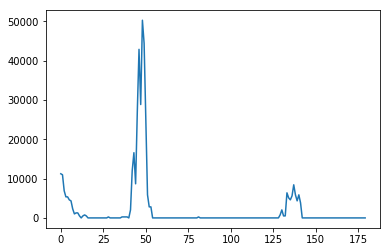

In [24]:
plt.plot(warped_img.sum(axis=0))

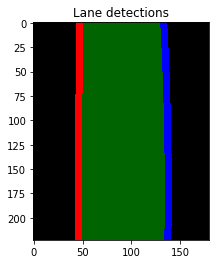

In [25]:
out_img, left_fit, right_fit = fit_polynomial(np.int16(warped_img), 10, 20, 0.001)

plt.title('Lane detections')
plt.imshow(out_img)
plt.show()

## Determine the curvature of the lane and vehicle position with respect to center.

In [26]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm = 3.7 # meters in x dimension

In [27]:
y_eval = out_img.shape[0]*ym_per_pix

left_curverad = np.int64( ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]) )
right_curverad = np.int64( ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]) )
print('Left lane Curvature: {}(m)\tRight lane Curvature: {}(m)'.format(left_curverad, right_curverad))

Left lane Curvature: 212529(m)	Right lane Curvature: 3322(m)


In [28]:
left_lane_pos = out_img[out_img.shape[0]//2+100:,:,0].sum(axis=0)[:out_img.shape[1]//2].argmax()
right_lane_pos = out_img[out_img.shape[0]//2+100:,:,2].sum(axis=0)[out_img.shape[1]//2:].argmax()+out_img.shape[1]//2
center_line = out_img.shape[1]//2
offset = np.round(100*((center_line-left_lane_pos)/(right_lane_pos-left_lane_pos)-0.5)*xm,2)
print('Offset: {}(cm)'.format(offset))

Offset: 4.02(cm)


## Warp the detected lane boundaries back onto the original image.

In [29]:
final_img = np.zeros_like(warper(combined_binary[450:(450+IMAGE_H)], src_p, dst_p))
final_img = np.dstack((final_img,final_img,final_img))
final_img[:,550:-550] = out_img
final_img = np.uint8(warper(final_img, dst_p, src_p))

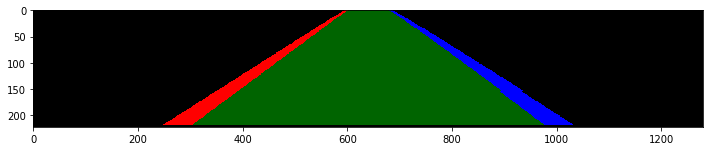

In [30]:
rcParams['figure.figsize'] = 12,7
plt.imshow(final_img, cmap='gray')

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

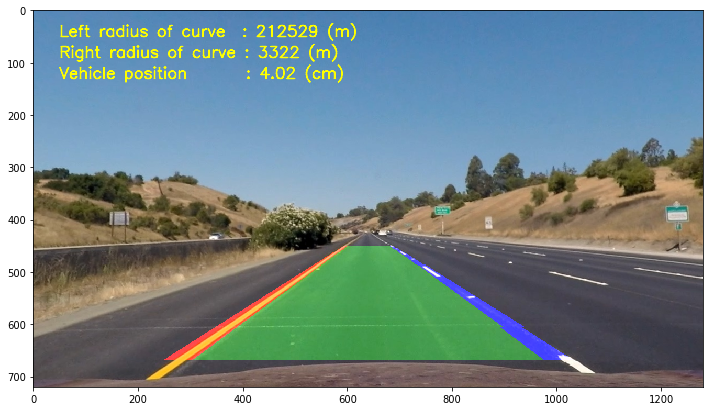

In [31]:
dst_lanes = dst.copy()
detection = np.zeros_like(dst_lanes)
detection[450:(450+IMAGE_H)] = final_img
dst_lanes = cv2.cv2.addWeighted(dst_lanes, 1, detection, 0.9, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
plt.imshow(cv2.putText(dst_lanes, 'Left radius of curve  : {} (m)'.format(left_curverad), (50,50), font, 1, (255, 255, 0), 2, cv2.LINE_AA))
plt.imshow(cv2.putText(dst_lanes, 'Right radius of curve : {} (m)'.format(right_curverad), (50,90), font, 1, (255, 255, 0), 2, cv2.LINE_AA))
plt.imshow(cv2.putText(dst_lanes, 'Vehicle position       : {} (cm)'.format(offset), (50,130), font, 1, (255, 255, 0), 2, cv2.LINE_AA))

## Final Pipeline

In [32]:
def process(src):
    ### DISTORTION CORRECTION
    dst = cv2.undistort(src, mtx, dist)
    
    ### THRESHOLDING USING A STUDENT PROPOSED FILTER
    ksize = 3 

    gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(9, 100))
    mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))
    S_binary = hls_thresh(dst, ctype='S',thresh=(130, 200))

    combined_binary = np.zeros_like(gradx)
    combined_binary[(((gradx == 1) & (mag_binary == 1) & (dir_binary == 1)) | (S_binary == 1)) ] = 1
    comb_threshold = combined_binary
    
    ### PERSPECTIVE TRANSFORM
    IMAGE_H = 223
    IMAGE_W = 1280

    src_p = np.float32([[0, IMAGE_H], [1207, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    dst_p = np.float32([[563, IMAGE_H], [711, IMAGE_H], [0, 0], [IMAGE_W, 0]])

    warped_img = warper(comb_threshold[450:(450+IMAGE_H)], src_p, dst_p)[:,550:-550]
    
    ### LANE DETECTION AND FITTING USING SLIDING WINDOWS
    out_img, left_fit, right_fit = fit_polynomial(np.uint8(warped_img), 10, 20, 0.001)
    
    ### CALCULATING OFFSET AND RADIUS OF CURVE
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm = 3.7 # meters in x dimension
    
    y_eval = out_img.shape[0]*ym_per_pix
    
    left_curverad = np.uint8( ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]) )
    right_curverad = np.uint8( ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]) )

    left_lane_pos = out_img[out_img.shape[0]//2+100:,:,0].sum(axis=0)[:out_img.shape[1]//2].argmax()
    right_lane_pos = out_img[out_img.shape[0]//2+100:,:,2].sum(axis=0)[out_img.shape[1]//2:].argmax()+out_img.shape[1]//2
    center_line = out_img.shape[1]//2
    offset = np.round(100*((center_line-left_lane_pos)/(right_lane_pos-left_lane_pos)-0.5)*xm,2)
    
    ### INVERSE PERSPECTIVE TRANSFORM
    final_img = np.zeros_like(warper(comb_threshold[450:(450+IMAGE_H)], src_p, dst_p))
    final_img = np.dstack((final_img,final_img,final_img))
    final_img[:,550:-550] = out_img
    final_img = np.uint8(warper(final_img, dst_p, src_p))
    
    detection = np.zeros_like(dst)
    detection[450:(450+IMAGE_H)] = final_img
    
    ### ADDING DETECTION TO THE UNDISTORTED IMAGE
    dst_lanes = cv2.addWeighted(dst, 1, detection, 0.9, 0)

    ### ADDING NUMERICAL ESTIMATION OF LANE CURVATURE AND VEHICLE POSITION
    font = cv2.FONT_HERSHEY_SIMPLEX
    plt.imshow(cv2.putText(dst_lanes, 'Left radius of curve  : {} (m)'.format(left_curverad), (50,50), font, 1, (255, 255, 0), 2, cv2.LINE_AA))
    plt.imshow(cv2.putText(dst_lanes, 'Right radius of curve : {} (m)'.format(right_curverad), (50,90), font, 1, (255, 255, 0), 2, cv2.LINE_AA))
    plt.imshow(cv2.putText(dst_lanes, 'Vehicle position       : {} (cm)'.format(offset), (50,130), font, 1, (255, 255, 0), 2, cv2.LINE_AA))
    
    return dst_lanes

## Testing on images

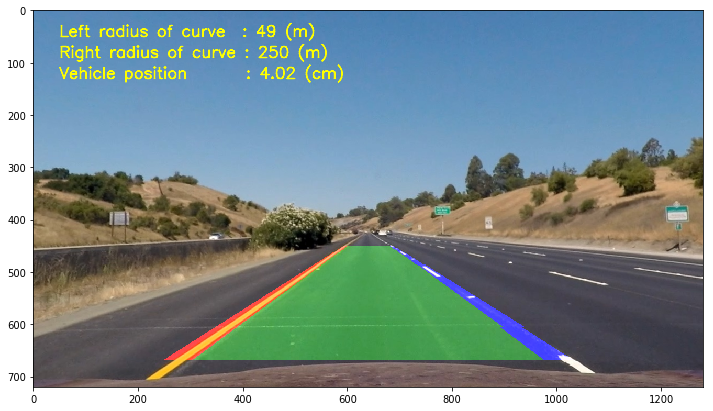

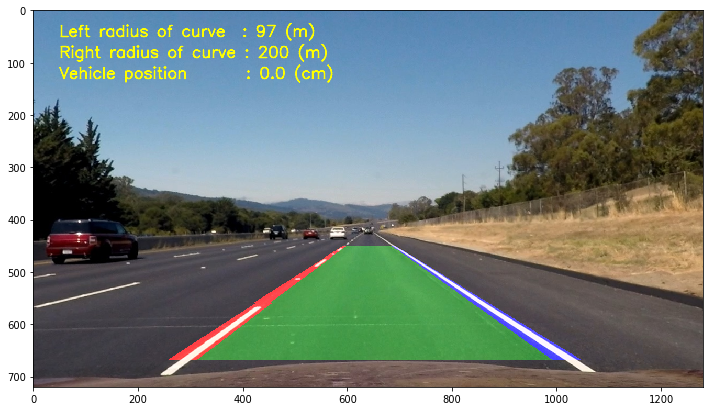

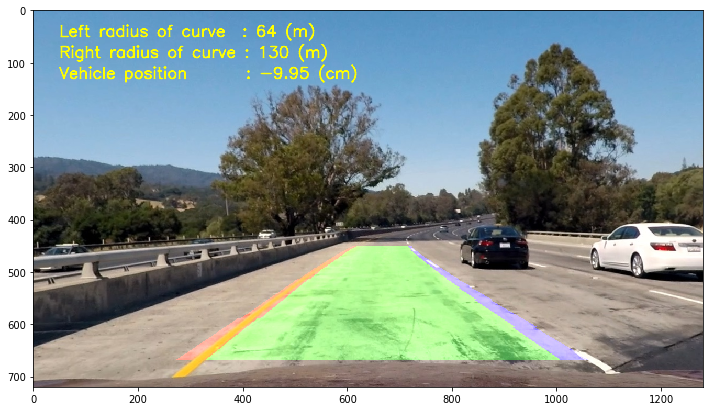

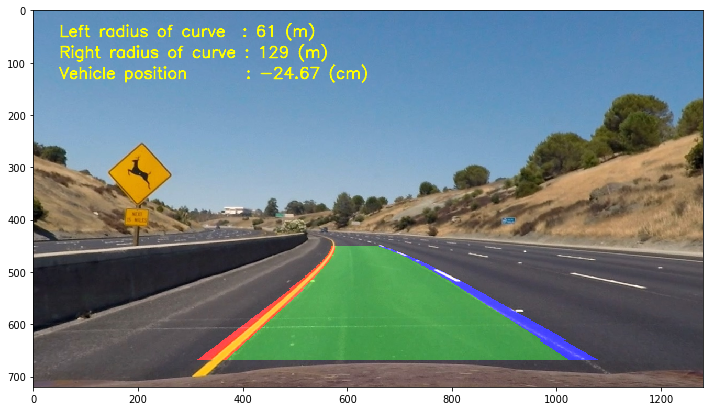

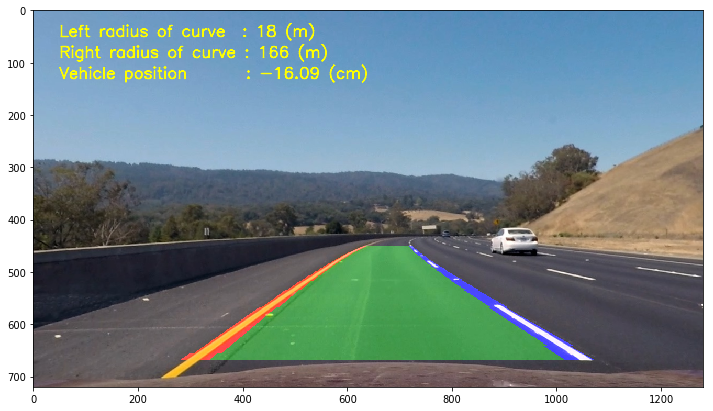

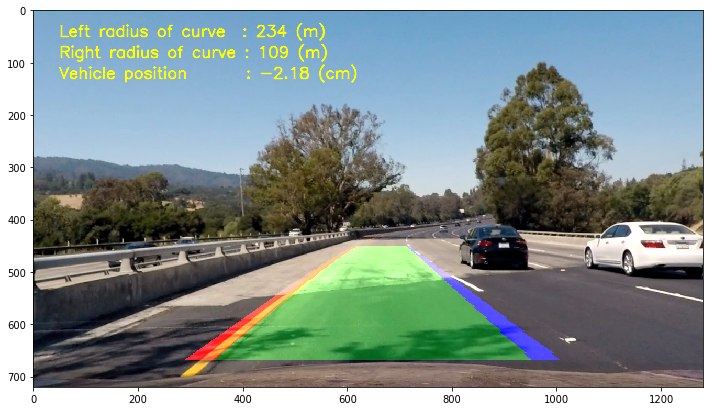

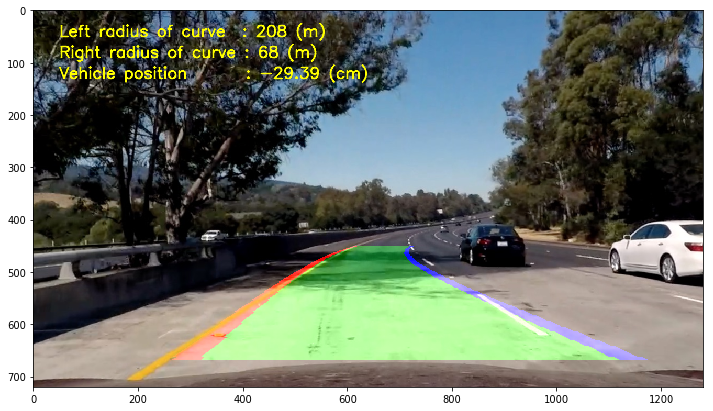

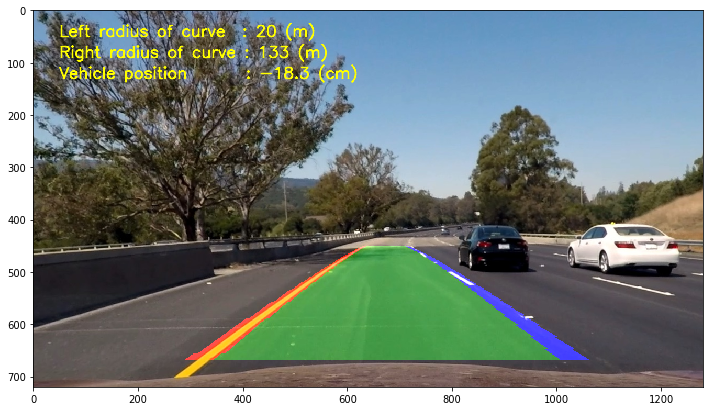

In [33]:
images = glob.glob('../test_images/*.jpg')
for fname in images:
    src = cv2.imread(fname)[:,:,::-1]
    plt.imshow(process(src))
    plt.show()

## Testing on a video

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [36]:
white_output = VideoFileClip("../project_video_output.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

OSError: [WinError 6] Descripteur non valide